In [1]:
from uf3.jax.jax_splines import *
from uf3.util.random import random_spline

import jax.numpy as jnp
from jax import jit, grad, vmap, value_and_grad
import jax

import numpy as onp

import ndsplines

import time
import timeit

import matplotlib.pyplot as plt
import matplotlib

from dataclasses import dataclass
from typing import Optional, Tuple
from pydantic import validate_arguments

from jax.config import config
config.update("jax_enable_x64", True)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Benchmarks for Splines

In [2]:
timings = {}
seed = 123

In [20]:
@validate_arguments
@dataclass(frozen=True)
class Setting():
    name: str
    dimension: Tuple[int,...]
    resolution: Tuple[int,...]
    degree: Tuple[int,...]
    implementation: str
    basis: Optional[BSplineBackend]
    backend: Optional[str]
    size: Tuple[int,...]


## The fastest backend for cubic splines
- (1D and 3D)
- CPU vs GPU

### 1D

In [4]:
A = Setting('Symbolic_CPU', [1], [20], [3], 'jax', BSplineBackend.Symbolic, 'cpu', [10e2,10e3,10e4,10e5,10e6,10e7,10e8])
B = Setting('Symbolic_GPU', [1], [20], [3], 'jax', BSplineBackend.Symbolic, 'gpu', [10e2,10e3,10e4,10e5,10e6,10e7])
C = Setting('DeBoor_CPU', [1], [20], [3], 'jax', BSplineBackend.DeBoor, 'cpu', [10e2,10e3,10e4,10e5,10e6,10e7,10e8])
D = Setting('DeBoor_GPU', [1], [20], [3], 'jax', BSplineBackend.DeBoor, 'gpu', [10e2,10e3,10e4,10e5,10e6,10e7])

one_d = [A,B,C,D]

### 3D

In [5]:
A = Setting('Symbolic_CPU', [3], [20], [3], 'jax', BSplineBackend.Symbolic, 'cpu', [10e2,10e3,10e4,10e5,10e6,10e7,10e8])
B = Setting('Symbolic_GPU', [3], [20], [3], 'jax', BSplineBackend.Symbolic, 'gpu', [10e2,10e3,10e4,10e5,10e6,10e7])
C = Setting('DeBoor_CPU', [3], [20], [3], 'jax', BSplineBackend.DeBoor, 'cpu', [10e2,10e3,10e4,10e5,10e6,10e7,10e8])
D = Setting('DeBoor_GPU', [3], [20], [3], 'jax', BSplineBackend.DeBoor, 'gpu', [10e2,10e3,10e4,10e5,10e6,10e7])

three_d = [A,B,C,D]

## Comparing to other implementations (1D cubic)

- JAX
- ndspline
- scipy

In [6]:
A = Setting('ndsplines', [1], [20], [3], 'ndsplines', None, None, [10e2,10e3,10e4,10e5,10e6,10e7, 10e8])
B = Setting('ndsplines', [3], [20], [3], 'ndsplines', None, None, [10e2,10e3,10e4,10e5,10e6,10e7, 10e8])
C = Setting('SciPy', [1], [20], [3], 'scipy', None, None, [10e2,10e3,10e4,10e5,10e6,10e7, 10e8])

other = [A,B,C]

## Effects of higher degrees (deBoor backend and ndspline)

In [7]:
A = Setting('DeBoor_CPU', [1], [40], [3,4,5,6,7,8,9,10], 'jax', BSplineBackend.DeBoor, 'cpu', [10e6])
B = Setting('DeBoor_GPU', [1], [40], [3,4,5,6,7,8,9,10], 'jax', BSplineBackend.DeBoor, 'gpu', [10e6])
C = Setting('ndsplines', [1], [40], [3,4,5,6,7,8,9,10], 'ndsplines', None, None, [10e6])

degree = [A,B,C]

## Effects of higher dimensions

In [8]:
A = Setting('DeBoor_CPU', [1,2,3,4,5], [20], [3], 'jax', BSplineBackend.DeBoor, 'cpu', [10e6])
B = Setting('DeBoor_GPU', [1,2,3,4,5], [20], [3], 'jax', BSplineBackend.DeBoor, 'gpu', [10e6])
C = Setting('ndsplines', [1,2,3,4,5], [20], [3], 'ndsplines', None, None, [10e6])

dimensions = [A,B,C]

## Effect of increased knot resolution

1D and 3D splines - fastest backend

In [9]:
A = Setting('Symbolic_CPU', [1], list(range(10,101,10)), [3], 'jax', BSplineBackend.Symbolic, 'cpu', [10e6])
B = Setting('Symbolic_GPU', [1], list(range(10,101,10)), [3], 'jax', BSplineBackend.Symbolic, 'gpu', [10e6])
C = Setting('DeBoor_CPU', [1], list(range(10,101,10)), [3], 'jax', BSplineBackend.DeBoor, 'cpu', [10e6])
D = Setting('DeBoor_GPU', [1], list(range(10,101,10)), [3], 'jax', BSplineBackend.DeBoor, 'gpu', [10e6])
E = Setting('ndsplines', [1], list(range(10,101,10)), [3], 'ndsplines', None, None, [10e6])

knots_1D = [A,B,C,D,E]

In [10]:
A = Setting('Symbolic_CPU', [3], list(range(10,101,10)), [3], 'jax', BSplineBackend.Symbolic, 'cpu', [10e6])
B = Setting('Symbolic_GPU', [3], list(range(10,101,10)), [3], 'jax', BSplineBackend.Symbolic, 'gpu', [10e6])
C = Setting('DeBoor_CPU', [3], list(range(10,101,10)), [3], 'jax', BSplineBackend.DeBoor, 'cpu', [10e6])
D = Setting('DeBoor_GPU', [3], list(range(10,101,10)), [3], 'jax', BSplineBackend.DeBoor, 'gpu', [10e6])
E = Setting('ndsplines', [3], list(range(10,101,10)), [3], 'ndsplines', None, None, [10e6])

knots_3D = [A,B,C,D,E]

In [21]:
A = Setting('test1', [1], [20,40], [3], 'jax', BSplineBackend.Symbolic, 'cpu', [10e2])
B = Setting('test2', [1,3], [20], [3], 'ndsplines', None, None, [10e2])

test = [A,B]

In [12]:
def run_benchmark(setting: Setting, repeats, max_time, seed=123):
    t_old = onp.zeros(1+repeats)

    if len(setting.dimension) > 1:
        for d in setting.dimension:
            new_s = Setting(
                setting.name,
                [d],
                setting.resolution,
                setting.degree,
                setting.implementation,
                setting.basis,
                setting.backend,
                setting.size,
            )
            t = run_setting(new_s, repeats, seed=seed)
            if t is None:
                warnings.warn(f"No result for {setting.name} at dimension {d}.")
                break
            t_new = onp.asarray([d] + t)
            t_old = onp.vstack([t_old, t_new])
        return t_old[1:,:]

    if len(setting.resolution) > 1:
        for r in setting.resolution:
            new_s = Setting(
                setting.name,
                setting.dimension,
                [r],
                setting.degree,
                setting.implementation,
                setting.basis,
                setting.backend,
                setting.size,
            )
            t = run_setting(new_s, repeats, seed=seed)
            if t is None:
                warnings.warn(f"No result for {setting.name} at resolution {r}.")
                break
            t_new = onp.asarray([r] + t)
            t_old = onp.vstack([t_old, t_new])
        return t_old[1:,:]

    if len(setting.degree) > 1:
        for d in setting.degree:
            new_s = Setting(
                setting.name,
                setting.dimension,
                setting.resolution,
                [d],
                setting.implementation,
                setting.basis,
                setting.backend,
                setting.size,
            )
            t = run_setting(new_s, repeats, seed=seed)
            if t is None:
                warnings.warn(f"No result for {setting.name} at degree {d}.")
                break
            t_new = onp.asarray([d] + t)
            t_old = onp.vstack([t_old, t_new])
        return t_old[1:,:]

    if len(setting.size) > 1:
        for s in setting.size:
            new_s = Setting(
                setting.name,
                setting.dimension,
                setting.resolution,
                setting.degree,
                setting.implementation,
                setting.basis,
                setting.backend,
                [s],
            )
            t = run_setting(new_s, repeats, seed=seed)
            if t is None:
                warnings.warn(f"No result for {setting.name} at size {s}.")
                break
            t_new = onp.asarray([s] + t)
            t_old = onp.vstack([t_old, t_new])
        return t_old[1:,:]
        
    raise ArgumentError("Exactly one setting parameter should be a list.")


def run_setting(setting: Setting, repeats, seed=123):
    dimension = int(setting.dimension[0])
    resolution = int(setting.resolution[0])
    degree = int(setting.degree[0])
    size = int(setting.size[0])

    res = (resolution,) * dimension
    ds = (degree,) * dimension

    c, k, x = random_spline(res, degrees=ds, sample=size, seed=seed)

    sym = None
    if setting.implementation == "jax":
        s = ndSpline_unsafe(c, k, ds, backend=setting.basis)

        x_jax = jax.device_put(x)

        fn = jit(vmap(s), backend=setting.backend)

        sym = lambda: fn(x_jax).block_until_ready()
    elif setting.implementation == "ndsplines":
        knots = []
        for a in k:
            knots.append(onp.asarray(a))
        s = ndsplines.NDSpline(knots, onp.asarray(c), ds)
        xs = onp.asarray(x)

        def fn():
            s(xs)

        sym = fn
    elif setting.implementation == "scipy":
        pass
    else:
        raise NotImplementedError(f"Implementation of {setting.implementation} not supported.")

    try:
        t = timeit.Timer(sym).repeat(repeat=repeats, number=1)
    except RuntimeError:
        return None

    return t



In [13]:
def benchmark(settings, repeats, max_time, seed=123):
    results = {}

    for s in settings:
        timeing = run_benchmark(s, repeats, max_time, seed)
        results[s] = timeing
    
    return results

In [24]:
timings = benchmark(test,4,1)


In [25]:
import pickle

with open("test_benchmark.bin", "wb") as f:
    pickle.dump(timings, f)



PicklingError: Can't pickle <class '__main__.Experiment_Setting'>: it's not the same object as __main__.Experiment_Setting

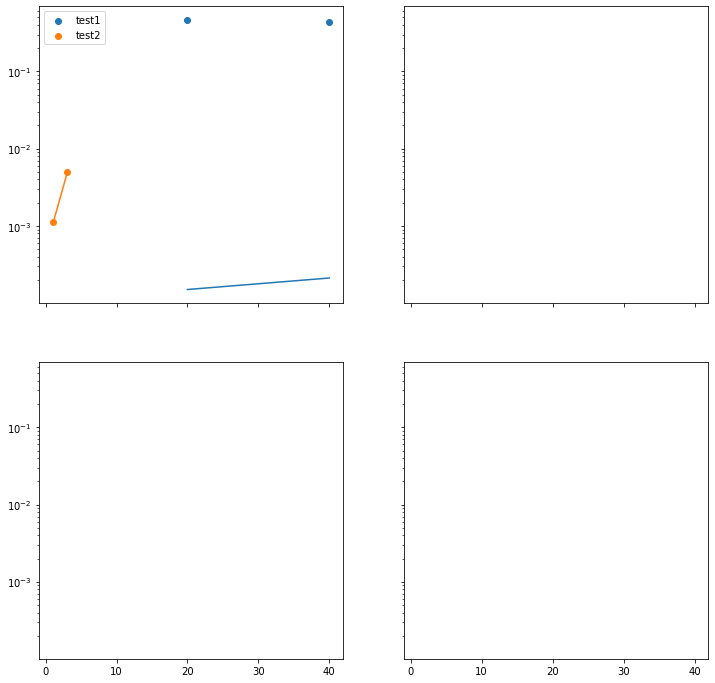

In [49]:

fig, axs = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

for setting in timings.keys():
    timeing = timings[setting]
    ax = axs[0,0]
    x = timeing[:,0]
    y_jit = timeing[:,1]
    y = onp.mean(timeing[:,2:], 1)

    ax.plot(x, y)
    # ax.set_xscale('log')
    ax.scatter(x, y_jit, label=setting.name)
    ax.set_yscale('log')
    ax.legend()


plt.show()